# Load the Dataset


In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np

np.random.seed(42)

pio.renderers.default = "notebook+notebook_connected+vscode"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("data/lightcast_job_postings.csv")

# Show Schema and Sample Data
# print("---This is Diagnostic check, No need to print it in the final doc---")

# df.printSchema() # comment this line when rendering the submission
# df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/08 00:43:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Feature Engineering


In [2]:
#| eval: true
#| echo: false
#| fig-align: center

from pyspark.sql.functions import col, pow
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Drop Missing Values in target variable and key features

df = df.dropna(subset=[
    "SALARY", "MIN_YEARS_EXPERIENCE","EMPLOYMENT_TYPE_NAME","REMOTE_TYPE_NAME",
    "DURATION", "IS_INTERNSHIP","COMPANY_IS_STAFFING", "STATE_NAME", "MIN_EDULEVELS_NAME"
])

# Selecting 2 categorical variables
categorical_cols =[
    "REMOTE_TYPE_NAME", "EMPLOYMENT_TYPE_NAME"
]

#Index and One-Hot encode
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

# Assemble base features (for GLR and Random Forrest)
from pyspark.sql.functions import col, pow
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

assembler = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE", "DURATION",
        "IS_INTERNSHIP", "COMPANY_IS_STAFFING"
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

# Build pipeline and transform
pipeline = Pipeline(stages=indexers + encoders + [assembler])
data = pipeline.fit(df).transform(df)

# Create squared term for Polynomical Regression
data = data.withColumn("MIN_YEARS_EXPERIENCE_SQ", pow(col("MIN_YEARS_EXPERIENCE"),2))

#Assemble polynomial features
assembler_poly = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE", "DURATION",
        "IS_INTERNSHIP", "COMPANY_IS_STAFFING"
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features_poly"
)

data = assembler_poly.transform(data)

data.select("SALARY","features", "features_poly").show(5, truncate=False)

# Split into training and testing sets (80% training, 20% testing)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Check number of records in each
print("Training Data Count:", train_data.count())
print("Testing Data Count:", test_data.count())

+------+--------------------------------------+--------------------------------------+
|SALARY|features                              |features_poly                         |
+------+--------------------------------------+--------------------------------------+
|192800|(9,[0,1,4,7],[6.0,55.0,1.0,1.0])      |(9,[0,1,4,7],[6.0,55.0,1.0,1.0])      |
|125900|(9,[0,1,4,7],[12.0,18.0,1.0,1.0])     |(9,[0,1,4,7],[12.0,18.0,1.0,1.0])     |
|118560|[5.0,20.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0]|[5.0,20.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0]|
|192800|(9,[0,1,4,7],[6.0,55.0,1.0,1.0])      |(9,[0,1,4,7],[6.0,55.0,1.0,1.0])      |
|116500|(9,[0,1,4,7],[12.0,16.0,1.0,1.0])     |(9,[0,1,4,7],[12.0,16.0,1.0,1.0])     |
+------+--------------------------------------+--------------------------------------+
only showing top 5 rows



25/10/08 00:44:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Training Data Count: 11604


Testing Data Count: 2812


# Train/Test Split


In [3]:
# Split into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Check number of records in each
print("Training Data Count:", train_data.count())
print("Testing Data Count:", test_data.count())

Training Data Count: 11604


Testing Data Count: 2812


- I chose the 80/20 split that was discussed during class, the data set is large enough that this split should be fine, and should account for enough of the data.

# Regression_DF


In [4]:
from pyspark.sql.functions import regexp_replace, trim, col
from pyspark.sql.types import IntegerType

regression_df = df.select(
    "SALARY",
    "MIN_YEARS_EXPERIENCE",
    "MAX_YEARS_EXPERIENCE",
    "DURATION",
    "IS_INTERNSHIP",
    "COMPANY_IS_STAFFING",
    "REMOTE_TYPE_NAME",
    "EMPLOYMENT_TYPE_NAME",
    "EDUCATION_LEVELS_NAME"
)

regression_df = regression_df.withColumn(
    "EDUCATION_LEVELS_NAME",
    trim(regexp_replace(col("EDUCATION_LEVELS_NAME"), r"[\.\-]", " "))
)

regression_df = regression_df.dropna(subset=[
    "SALARY",
    "MIN_YEARS_EXPERIENCE",
    "MAX_YEARS_EXPERIENCE",
    "DURATION",
    "IS_INTERNSHIP",
    "COMPANY_IS_STAFFING",
    "REMOTE_TYPE_NAME",
    "EMPLOYMENT_TYPE_NAME",
    "EDUCATION_LEVELS_NAME"
])

# Convert Duration to numeric (in days)
regression_df =regression_df.withColumn("DURATION", col("DURATION").cast(IntegerType()))

regression_df.show(5, truncate=False)

+------+--------------------+--------------------+--------+-------------+-------------------+----------------+----------------------+------------------------------------------------------------------------------------+
|SALARY|MIN_YEARS_EXPERIENCE|MAX_YEARS_EXPERIENCE|DURATION|IS_INTERNSHIP|COMPANY_IS_STAFFING|REMOTE_TYPE_NAME|EMPLOYMENT_TYPE_NAME  |EDUCATION_LEVELS_NAME                                                               |
+------+--------------------+--------------------+--------+-------------+-------------------+----------------+----------------------+------------------------------------------------------------------------------------+
|131100|2                   |2                   |11      |false        |false              |[None]          |Full-time (> 32 hours)|[\n  "Bachelor's degree"\n]                                                         |
|136950|3                   |3                   |28      |false        |false              |Remote          |Full-time (> 3

# Linear Regression Model (OLS)


In [5]:
from pyspark.sql.functions import regexp_replace, trim

regression_df = regression_df.withColumn("EDUCATION_LEVELS_NAME", trim(regexp_replace(col("EDUCATION_LEVELS_NAME"), r"[\.\-]", " ")))

# Index and One-Hot Encode
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

# Assemble base features (for GLR and Random Forrest)
assembler = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE", "DURATION",
        "IS_INTERNSHIP", "COMPANY_IS_STAFFING"
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

pipeline_reg = Pipeline(stages=indexers + encoders + [assembler])
regression_data = pipeline_reg.fit(regression_df).transform(regression_df)

regression_data.select("SALARY","features").show(5, truncate=False)

+------+---------------------------------------+
|SALARY|features                               |
+------+---------------------------------------+
|131100|(10,[0,1,2,5,8],[2.0,2.0,11.0,1.0,1.0])|
|136950|(10,[0,1,2,6,8],[3.0,3.0,28.0,1.0,1.0])|
|136950|(10,[0,1,2,6,8],[3.0,3.0,28.0,1.0,1.0])|
|104000|(10,[0,1,2,5,8],[3.0,3.0,8.0,1.0,1.0]) |
|80000 |(10,[0,1,2,5,8],[3.0,3.0,37.0,1.0,1.0])|
+------+---------------------------------------+
only showing top 5 rows



In [6]:
# Split Data
regression_train, regression_test = regression_data.randomSplit([0.8, 0.2], seed=42)
print((regression_data.count(), len(regression_data.columns)))
print((regression_train.count(), len(regression_train.columns)))
print((regression_test.count(), len(regression_test.columns)))

(2243, 14)


(1848, 14)


(395, 14)


In [7]:
from pyspark.ml.regression import GeneralizedLinearRegression, LinearRegression

feature_names = assembler.getInputCols()

glr = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="SALARY",
    family="gaussian",
    link="identity",
    maxIter=10,
    regParam=0.3
)

glr_model = glr.fit(regression_data)
summary = glr_model.summary

In [8]:
# Coefficients and Intercept
print("Intercept: {:.4f}".format(glr_model.intercept))
print("Coefficients: ")
for i, coef in enumerate(glr_model.coefficients):
    print(f"  Feature {i + 1}: {coef:.4f}")

Intercept: 75819.4000
Coefficients: 
  Feature 1: 4215.6844
  Feature 2: 4215.6844
  Feature 3: -23.7725
  Feature 4: -23942.2288
  Feature 5: -98.6466
  Feature 6: 6430.6643
  Feature 7: 16463.9439
  Feature 8: 655.1948
  Feature 9: -9251.7034
  Feature 10: -12761.7200


In [9]:
# Summary stats

print("\n---Regression Summary---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in summary.coefficientStandardErrors])
print("T-values:", [f"{val:.4f}" for val in summary.tValues])
print("P-values:", [f"{val:.4f}" for val in summary.pValues])


---Regression Summary---


Coefficient Standard Errors: ['57432.0320', '57432.0320', '40.9532', '12518.4270', '1651.7511', '5327.5134', '5421.5678', '6892.7578', '7503.5432', '8182.7045', '9011.3793']
T-values: ['0.0734', '0.0734', '-0.5805', '-1.9126', '-0.0597', '1.2071', '3.0367', '0.0951', '-1.2330', '-1.5596', '8.4137']
P-values: ['0.9415', '0.9415', '0.5617', '0.0559', '0.9524', '0.2275', '0.0024', '0.9243', '0.2177', '0.1190', '0.0000']


In [10]:
print(f"nullDeviance: {summary.nullDeviance:.4f}")
print(f"Residual DF Null: {summary.residualDegreeOfFreedom}")
print(f"Residual DF: {summary.residualDegreeOfFreedom}")
print(f"AIC: {summary.aic:.4f}")
print(f"Deviance: {summary.deviance:.4f}")
explained_variance_deviance = (summary.nullDeviance - summary.deviance) / summary.nullDeviance
print("Explained Variance (from deviance):", explained_variance_deviance)

nullDeviance: 2728391925894.5732
Residual DF Null: 2232
Residual DF: 2232


AIC: 52299.8485
Deviance: 1738269402130.5212
Explained Variance (from deviance): 0.3628960027212421


In [11]:
# Pull feature names directly from Java backend

feature_names = summary._call_java("featureNames")

# Construct full table including intercept
features = ["Intercept"] + feature_names
coef = [glr_model.intercept] + list(glr_model.coefficients)
se = list(summary.coefficientStandardErrors)
tvals = list(summary.tValues)
pvals = list(summary.pValues)

print("Length of features:", len(features))
print("Length of coefficients:", len(coef))
print("Length of standard errors:", len(se))
print("Length of t-values:", len(tvals))
print("Length of p-values:", len(pvals))

Length of features: 11
Length of coefficients: 11
Length of standard errors: 11
Length of t-values: 11
Length of p-values: 11


In [12]:
import pandas as pd
from tabulate import tabulate
from IPython.display import HTML

coef_table = pd.DataFrame({
    "Features": features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in coef],
    "Std. Error": [f"{v:.4f}" if v is not None else None for v in se],
    "t value": [f"{v:.4f}" if v is not None else None for v in tvals],
    "P-value": [f"{v:.4f}" if v is not None else None for v in pvals]
})

# Save Report
coef_table.to_csv("output/glr_summary.csb", index=False)

# Optional pretty print

HTML (coef_table.to_html())

,Features,Estimate,Std. Error,t value,P-value
0,Intercept,75819.4000,57432.0320,0.0734,0.9415
1,MIN_YEARS_EXPERIENCE,4215.6844,57432.0320,0.0734,0.9415
2,MAX_YEARS_EXPERIENCE,4215.6844,40.9532,-0.5805,0.5617
3,DURATION,-23.7725,12518.4270,-1.9126,0.0559
4,IS_INTERNSHIP,-23942.2288,1651.7511,-0.0597,0.9524
5,COMPANY_IS_STAFFING,-98.6466,5327.5134,1.2071,0.2275
6,REMOTE_TYPE_NAME_vec_[None],6430.6643,5421.5678,3.0367,0.0024
7,REMOTE_TYPE_NAME_vec_Remote,16463.9439,6892.7578,0.0951,0.9243
8,REMOTE_TYPE_NAME_vec_Hybrid Remote,655.1948,7503.5432,-1.2330,0.2177
9,EMPLOYMENT_TYPE_NAME_vec_Full-time (> 32 hours),-9251.7034,8182.7045,-1.5596,0.1190


# Generalized Linear Regression Summary
Based on the features, two significant predictors of salary include remote type name, and employment type name (part time). This makes sense when looking at the data, as remote work tends to pay higher than in person work, so jobs that are broken up by remote, hybrid, or onsite will have different pay scales, while employment type names will be broken up differently because of the difference in salary between part time and full time work. The coefficients have two features that have significant predictors, feature 6 is a positive predictor while feature 10 is a negative predictor. Other features do not have meaningful impacts on the target. The model performance is moderate and could be improved.
- Performance
    - Based on the Explained Variance this model is calculated to have a ~36% of the varience in salary which indicates that there is a moderate performance, but there is still room for improvement.
- Other Features
    - Years of experience, Internships, Full time employment are not significant predictors of salary in this model. This does not mean that they do not have significant impacts on salary as a whole, it just means that in terms of this model that there is not a trend that indicates that these features have a significant impact on salary.

# Polynomical Regression


In [13]:
#| eval: true
#| echo: false
#| fig-align: center

# Index and One-Hot encode

poly_data = regression_data.withColumn("MIN_YEARS_EXPERIENCE_SQ", pow(col("MIN_YEARS_EXPERIENCE"),2))

assembler_poly = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE", "MIN_YEARS_EXPERIENCE_SQ", "MAX_YEARS_EXPERIENCE", "DURATION",
        "IS_INTERNSHIP", "COMPANY_IS_STAFFING"
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features_poly"
)  

poly_data = assembler_poly.transform(poly_data)

poly_data.select("SALARY","features_poly").show(5, truncate=False)

+------+---------------------------------------------+
|SALARY|features_poly                                |
+------+---------------------------------------------+
|131100|(11,[0,1,2,3,6,9],[2.0,4.0,2.0,11.0,1.0,1.0])|
|136950|(11,[0,1,2,3,7,9],[3.0,9.0,3.0,28.0,1.0,1.0])|
|136950|(11,[0,1,2,3,7,9],[3.0,9.0,3.0,28.0,1.0,1.0])|
|104000|(11,[0,1,2,3,6,9],[3.0,9.0,3.0,8.0,1.0,1.0]) |
|80000 |(11,[0,1,2,3,6,9],[3.0,9.0,3.0,37.0,1.0,1.0])|
+------+---------------------------------------------+
only showing top 5 rows



In [14]:
# Split Data
polyreg_train, polyreg_test = poly_data.randomSplit([0.8, 0.2], seed=42)
print((poly_data.count(), len(poly_data.columns)))
print((polyreg_train.count(), len(polyreg_train.columns)))
print((polyreg_test.count(), len(polyreg_test.columns)))

(2243, 16)


(1848, 16)


(395, 16)


In [15]:
from pyspark.ml.regression import GeneralizedLinearRegression, LinearRegression

feature_names = assembler.getInputCols()

poly_glr_max_years_model = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="SALARY",
    family="gaussian",
    link="identity",
    maxIter=10,
    regParam=0.3
)

poly_glr_max_years_model = poly_glr_max_years_model.fit(poly_data)
poly_summary = poly_glr_max_years_model.summary

In [16]:
# Coefficients and Intercept
print("Intercept: {:.4f}".format(poly_glr_max_years_model.intercept))
print("Coefficients: ")
for i, coef in enumerate(poly_glr_max_years_model.coefficients):
    print(f"  Feature {i + 1}: {coef:.4f}")

    # Summary stats

print("\n---Regression Summary---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in poly_summary.coefficientStandardErrors])
print("T-values:", [f"{val:.4f}" for val in poly_summary.tValues])
print("P-values:", [f"{val:.4f}" for val in poly_summary.pValues])

Intercept: 75819.4000
Coefficients: 
  Feature 1: 4215.6844
  Feature 2: 4215.6844
  Feature 3: -23.7725
  Feature 4: -23942.2288
  Feature 5: -98.6466
  Feature 6: 6430.6643
  Feature 7: 16463.9439
  Feature 8: 655.1948
  Feature 9: -9251.7034
  Feature 10: -12761.7200

---Regression Summary---


Coefficient Standard Errors: ['57432.0320', '57432.0320', '40.9532', '12518.4270', '1651.7511', '5327.5134', '5421.5678', '6892.7578', '7503.5432', '8182.7045', '9011.3793']
T-values: ['0.0734', '0.0734', '-0.5805', '-1.9126', '-0.0597', '1.2071', '3.0367', '0.0951', '-1.2330', '-1.5596', '8.4137']
P-values: ['0.9415', '0.9415', '0.5617', '0.0559', '0.9524', '0.2275', '0.0024', '0.9243', '0.2177', '0.1190', '0.0000']


In [17]:
print(f"nullDeviance: {poly_summary.nullDeviance:.4f}")
print(f"Residual DF Null: {poly_summary.residualDegreeOfFreedom}")
print(f"Residual DF: {poly_summary.residualDegreeOfFreedom}")
print(f"AIC: {poly_summary.aic:.4f}")
print(f"Deviance: {poly_summary.deviance:.4f}")
poly_explained_variance_deviance = (poly_summary.nullDeviance - poly_summary.deviance) / poly_summary.nullDeviance
print("Explained Variance (from deviance):", poly_explained_variance_deviance)

nullDeviance: 2728391925894.5732
Residual DF Null: 2232
Residual DF: 2232


AIC: 52299.8485
Deviance: 1738269402130.5212
Explained Variance (from deviance): 0.3628960027212421


In [18]:
# Pull feature names directly from Java backend

feature_names = poly_summary._call_java("featureNames")

# Construct full table including intercept
poly_features = ["Intercept"] + feature_names
poly_coef = [poly_glr_max_years_model.intercept] + list(poly_glr_max_years_model.coefficients)
poly_se = list(poly_summary.coefficientStandardErrors)
poly_tvals = list(poly_summary.tValues)
poly_pvals = list(poly_summary.pValues)

print("Length of features:", len(poly_features))
print("Length of coefficients:", len(poly_coef))
print("Length of standard errors:", len(poly_se))
print("Length of t-values:", len(poly_tvals))
print("Length of p-values:", len(poly_pvals))

Length of features: 11
Length of coefficients: 11
Length of standard errors: 11
Length of t-values: 11
Length of p-values: 11


In [19]:
import pandas as pd
from tabulate import tabulate
from IPython.display import HTML

poly_coef_table = pd.DataFrame({
    "Features": poly_features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in poly_coef],
    "Std. Error": [f"{v:.4f}" if v is not None else None for v in poly_se],
    "t value": [f"{v:.4f}" if v is not None else None for v in poly_tvals],
    "P-value": [f"{v:.4f}" if v is not None else None for v in poly_pvals]
})

# Save Report
poly_coef_table.to_csv("output/poly_summary.csb", index=False)

# Optional pretty print

HTML (poly_coef_table.to_html())

,Features,Estimate,Std. Error,t value,P-value
0,Intercept,75819.4000,57432.0320,0.0734,0.9415
1,MIN_YEARS_EXPERIENCE,4215.6844,57432.0320,0.0734,0.9415
2,MAX_YEARS_EXPERIENCE,4215.6844,40.9532,-0.5805,0.5617
3,DURATION,-23.7725,12518.4270,-1.9126,0.0559
4,IS_INTERNSHIP,-23942.2288,1651.7511,-0.0597,0.9524
5,COMPANY_IS_STAFFING,-98.6466,5327.5134,1.2071,0.2275
6,REMOTE_TYPE_NAME_vec_[None],6430.6643,5421.5678,3.0367,0.0024
7,REMOTE_TYPE_NAME_vec_Remote,16463.9439,6892.7578,0.0951,0.9243
8,REMOTE_TYPE_NAME_vec_Hybrid Remote,655.1948,7503.5432,-1.2330,0.2177
9,EMPLOYMENT_TYPE_NAME_vec_Full-time (> 32 hours),-9251.7034,8182.7045,-1.5596,0.1190


# Poly Regression Summary

This data has similar impacts to the Linear regression model, Remote_TYPE_NAME having a positive impact and Employment_TYPE_NAME (part time) have a negative impact which are significant predictors of salary according to this model. While other features are not significant predictors. The model performance is the same based on the explained varience which is at 36%.

# Random Forest Regression


In [20]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Create the Random Forest Regressor model
rf = RandomForestRegressor(
    featuresCol="features", 
    labelCol="SALARY",   
    numTrees=300,        
    maxDepth=6,          
    seed=42
)

# Train the model on training data
rf_model = rf.fit(polyreg_train)

# Make predictions on test data
rf_predictions = rf_model.transform(polyreg_test)

# Evaluate model performance
evaluator = RegressionEvaluator(
    labelCol="SALARY", 
    predictionCol="prediction", 
    metricName="rmse"
)

rmse = evaluator.evaluate(rf_predictions)
r2 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "r2"})

print(f"Random Forest RMSE: {rmse:.4f}")
print(f"Random Forest R²: {r2:.4f}")


print("Feature Importances:", rf_model.featureImportances)

25/10/08 00:46:54 WARN DAGScheduler: Broadcasting large task binary with size 1546.5 KiB
25/10/08 00:46:55 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


Random Forest RMSE: 24624.2976
Random Forest R²: 0.4558
Feature Importances: (10,[0,1,2,3,4,5,6,7,8,9],[0.4790147073653835,0.3444487354194342,0.09395909200951295,0.0014699100208343343,0.019885592865900418,0.015141883605094464,0.030348076324909136,0.0036327841559004475,0.006208999364022691,0.005890218869007941])


# Feature Importance Plot


/tmp/ipykernel_1540/4249483686.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




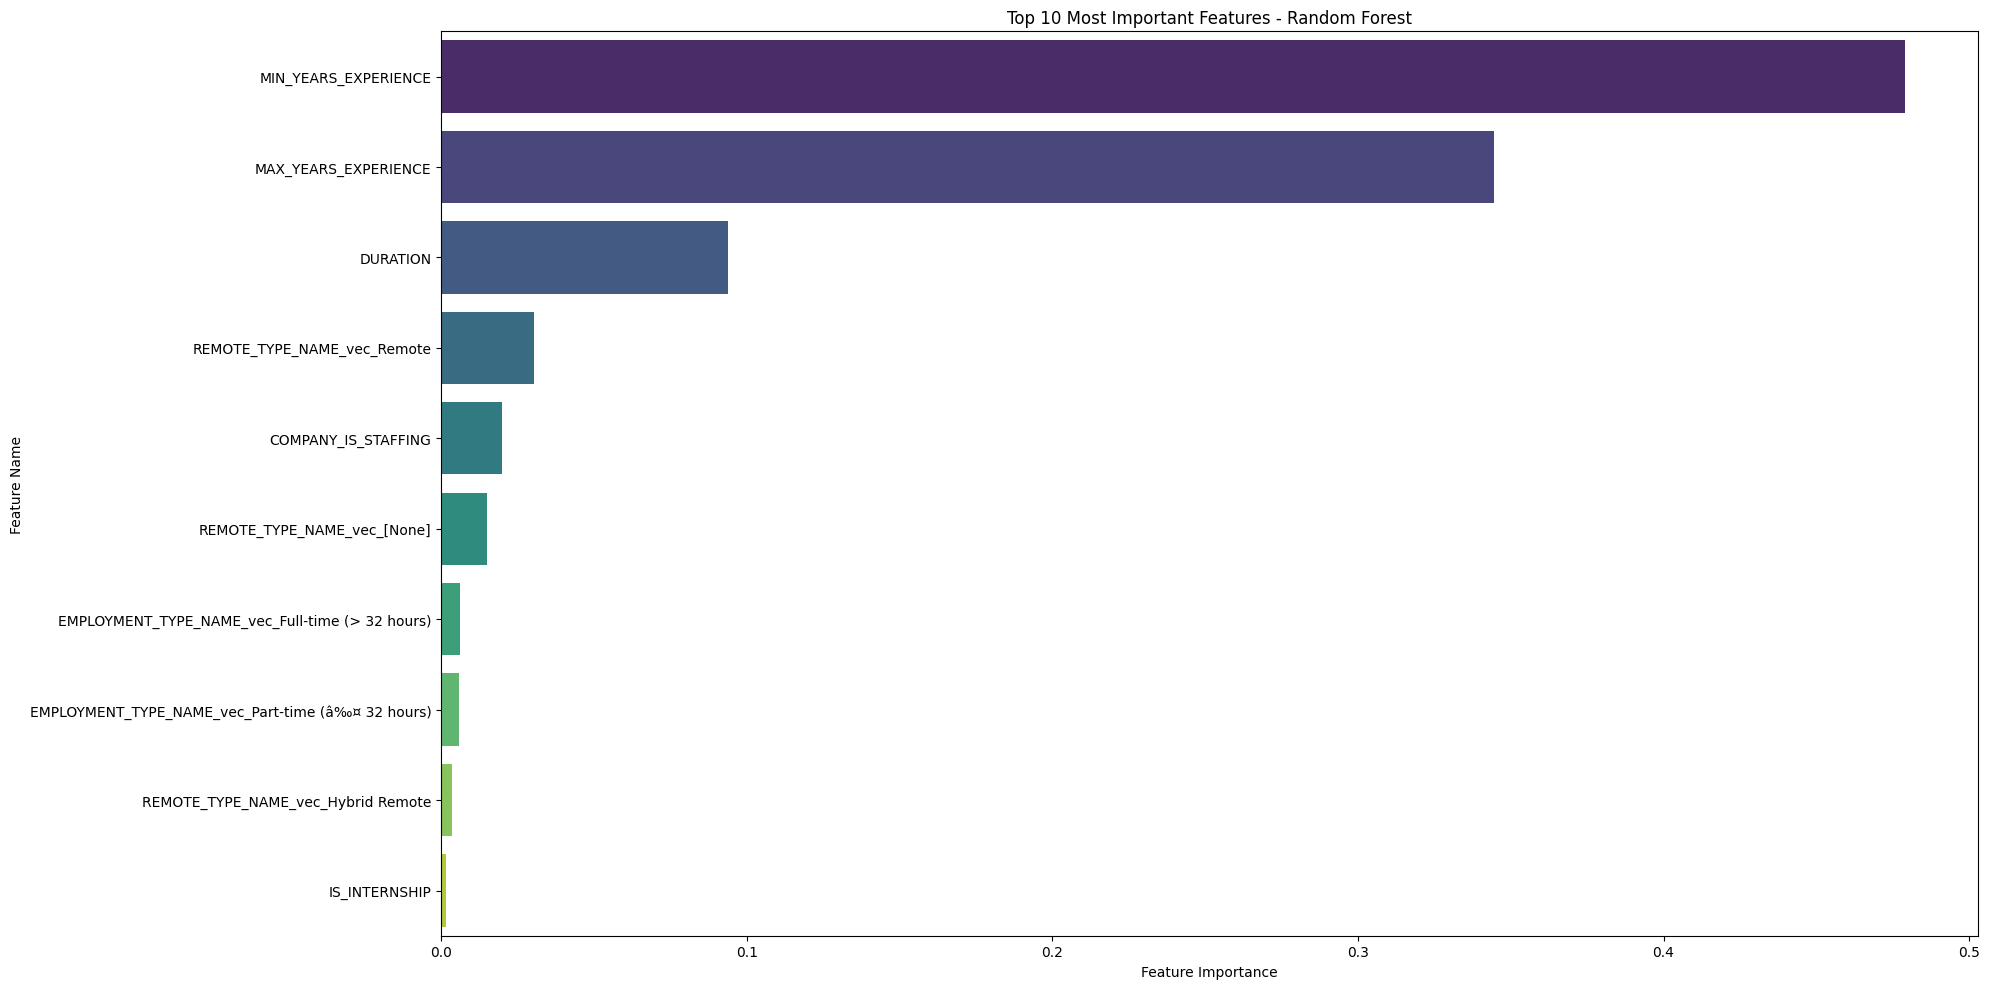

,Feature,Importance
0,MIN_YEARS_EXPERIENCE,0.479015
1,MAX_YEARS_EXPERIENCE,0.344449
2,DURATION,0.093959
6,REMOTE_TYPE_NAME_vec_Remote,0.030348
4,COMPANY_IS_STAFFING,0.019886
5,REMOTE_TYPE_NAME_vec_[None],0.015142
8,EMPLOYMENT_TYPE_NAME_vec_Full-time (> 32 hours),0.006209
9,EMPLOYMENT_TYPE_NAME_vec_Part-time (â‰¤ 32 hours),0.005890
7,REMOTE_TYPE_NAME_vec_Hybrid Remote,0.003633
3,IS_INTERNSHIP,0.001470


In [21]:
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import os

importances = rf_model.featureImportances.toArray()

min_len = min(len(feature_names), len(importances))
importance_df = pd.DataFrame({
    "Feature": feature_names[:min_len],
    "Importance": importances[:min_len]
})

top10 = importance_df.sort_values(by="Importance", ascending=False).head(10)

# Plot
plt.figure(figsize=(20, 10))
sns.barplot(x="Importance", y="Feature", data=top10, palette="viridis")
plt.title("Top 10 Most Important Features - Random Forest")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.tight_layout()

# Used AI to help me display dataframe as I was getting the error for length mismatch (See Appendix 1 in AI_Prompts.qmd)
# Matching lengths to make sure dataframe correctly renders
min_len = min(len(feature_names), len(importances))
feature_names, importances = feature_names[:min_len], importances[:min_len]

featureimportanceplot_df= pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

featureimportanceplot_df = featureimportanceplot_df.head(10)

# Save and show
plt.savefig("_output/rf_feature_importance.png", dpi=300)
plt.show()
featureimportanceplot_df

# Compare 3 Models - GLR,  Polynomial, RF


Model Comparison Metrics:
            Model          RMSE           AIC           BIC
0             GLR  27838.376618  52299.848476  45995.361481
1  Polynomial GLR  27838.376618  52299.848476  45995.361481
2   Random Forest  24624.297584           NaN   8047.865121


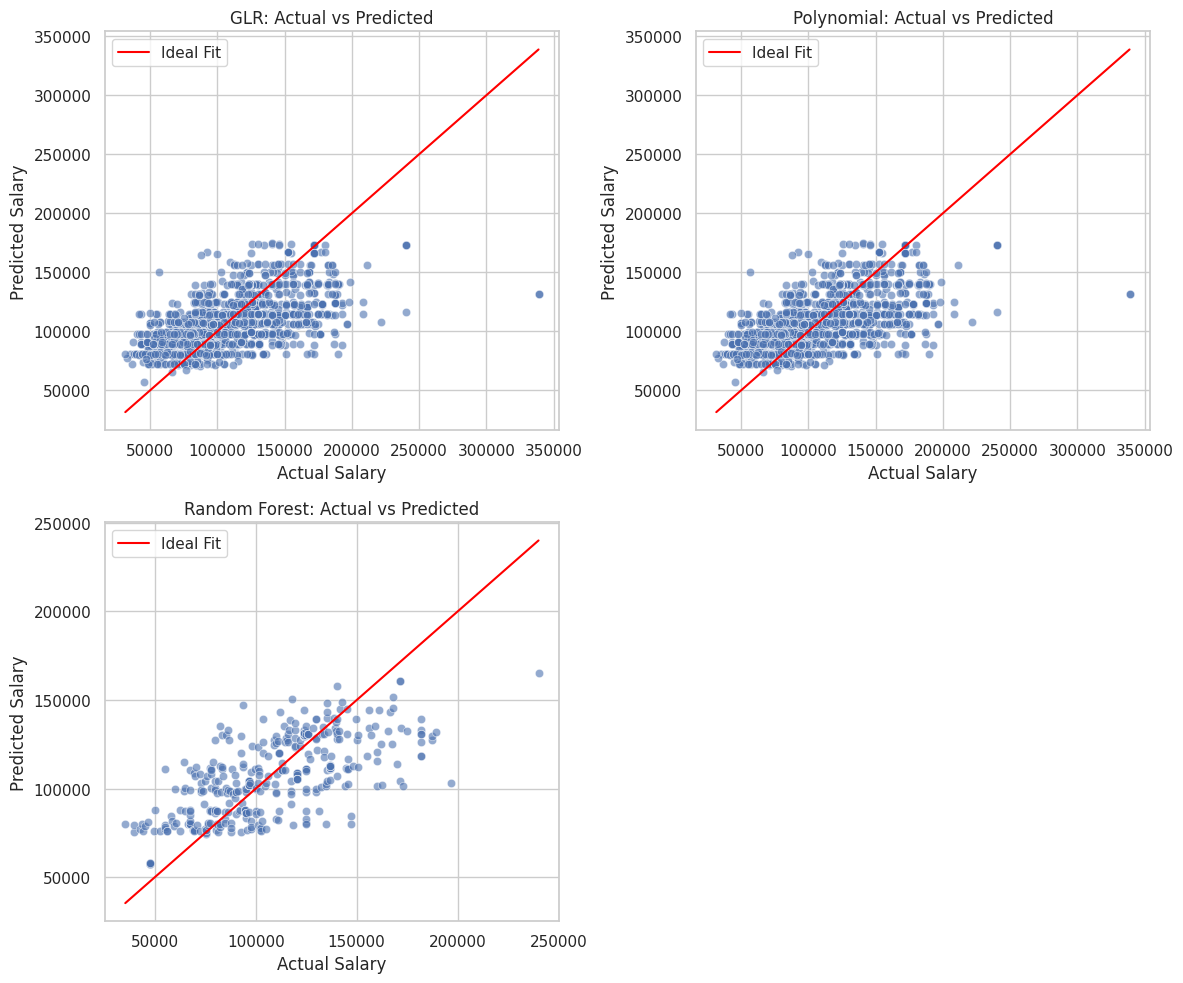

In [22]:
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions for each model
glr_predictions = glr_model.transform(regression_data)
poly_predictions = poly_glr_max_years_model.transform(poly_data)
rf_predictions = rf_model.transform(polyreg_test)

# RMSE for each model
evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")

glr_rmse = evaluator.evaluate(glr_predictions)
poly_rmse = evaluator.evaluate(poly_predictions)
rf_rmse = evaluator.evaluate(rf_predictions)

# AIC and BIC for each Model
# AIC is already available in the summary for GLR models
glr_aic = summary.aic
poly_aic = poly_summary.aic

# Manual BIC calculation
def calculate_bic(n, mse, k):
    return n * np.log(mse) + k * np.log(n)

# Count observations and parameters
n_glr = glr_predictions.count()
n_poly = poly_predictions.count()
n_rf = rf_predictions.count()

# Compute mean squared error (for BIC)
glr_mse = glr_rmse**2
poly_mse = poly_rmse**2
rf_mse = rf_rmse**2

# Number of parameters (approx: # features + intercept)
k_glr = len(glr_model.coefficients) + 1
k_poly = len(poly_glr_max_years_model.coefficients) + 1
k_rf = len(rf_model.featureImportances)

# Compute BIC
glr_bic = calculate_bic(n_glr, glr_mse, k_glr)
poly_bic = calculate_bic(n_poly, poly_mse, k_poly)
rf_bic = calculate_bic(n_rf, rf_mse, k_rf)

# Summarized model metrics
metrics_df = pd.DataFrame({
    "Model": ["GLR", "Polynomial GLR", "Random Forest"],
    "RMSE": [glr_rmse, poly_rmse, rf_rmse],
    "AIC": [glr_aic, poly_aic, np.nan],  # AIC not standard for RF
    "BIC": [glr_bic, poly_bic, rf_bic]
})

print("Model Comparison Metrics:")
print(metrics_df)

# Pandas DataFrame for visualization
glr_pd = glr_predictions.select("SALARY", "prediction").toPandas().assign(Model="GLR")
poly_pd = poly_predictions.select("SALARY", "prediction").toPandas().assign(Model="Polynomial")
rf_pd = rf_predictions.select("SALARY", "prediction").toPandas().assign(Model="Random Forest")

combined_pd = pd.concat([glr_pd, poly_pd, rf_pd])

# Plot Actual vs Predicted in a 2x2 grid ---
sns.set(style="whitegrid", context="notebook")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

models = ["GLR", "Polynomial", "Random Forest"]
for i, model in enumerate(models):
    ax = axes.flat[i]
    subset = combined_pd[combined_pd["Model"] == model]
    sns.scatterplot(x="SALARY", y="prediction", data=subset, alpha=0.6, ax=ax)
    sns.lineplot(x=subset["SALARY"], y=subset["SALARY"], color="red", ax=ax, label="Ideal Fit")
    ax.set_title(f"{model}: Actual vs Predicted")
    ax.set_xlabel("Actual Salary")
    ax.set_ylabel("Predicted Salary")

# Hide the 4th empty subplot
axes.flat[-1].axis('off')

plt.tight_layout()
plt.show()

# Calcutlating Log-Likelihood and BIC for Pyspark Models


In [23]:
import numpy as np

def log_likelihood(n, deviance, dispersion):
    """
    Compute log-likelihood for GLR (Gaussian / identity link)
    Formula: -0.5 * (n*log(2*pi) + n*log(dispersion) + deviance/dispersion)
    """
    return -0.5 * (n * np.log(2 * np.pi) + n * np.log(dispersion) + deviance / dispersion)

def bic(n, k, ll):
    """
    Compute BIC
    BIC = k * log(n) - 2 * log-likelihood
    """
    return k * np.log(n) - 2 * ll

# --- GLR Model ---
n_glr = glr_predictions.count()
deviance_glr = summary.deviance
dispersion_glr = deviance_glr / summary.residualDegreeOfFreedom
ll_glr = log_likelihood(n_glr, deviance_glr, dispersion_glr)
k_glr = len(glr_model.coefficients) + 1  # coefficients + intercept
bic_glr = bic(n_glr, k_glr, ll_glr)

# --- Polynomial GLR Model ---
n_poly = poly_predictions.count()
deviance_poly = poly_summary.deviance
dispersion_poly = deviance_poly / poly_summary.residualDegreeOfFreedom
ll_poly = log_likelihood(n_poly, deviance_poly, dispersion_poly)
k_poly = len(poly_glr_max_years_model.coefficients) + 1
bic_poly = bic(n_poly, k_poly, ll_poly)

print(f"GLR BIC: {bic_glr:.4f}")
print(f"Polynomial GLR BIC: {bic_poly:.4f}")

GLR BIC: 52360.7468
Polynomial GLR BIC: 52360.7468
